In [4]:
! pip install -q git+https://github.com/tensorflow/examples.git
! pip install -q -U tfds-nightly

In [1]:
import tensorflow as tf
from tensorflow_examples.models.pix2pix import pix2pix
import tensorflow_datasets as tfds
from IPython.display import clear_output, display
import matplotlib.pyplot as plt

2025-02-09 13:40:14.608054: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-09 13:40:14.767079: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [9]:
dataset, info = tfds.load('oxford_iiit_pet:4.*.*', with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 245 extraneous bytes before marker 0xd9


Shuffling /home/noxiusk/tensorflow_datasets/oxford_iiit_pet/incomplete.M9D6G1_4.0.0/oxford_iiit_pet-train.tfre…

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /home/noxiusk/tensorflow_datasets/oxford_iiit_pet/incomplete.M9D6G1_4.0.0/oxford_iiit_pet-test.tfrec…

Dataset oxford_iiit_pet downloaded and prepared to /home/noxiusk/tensorflow_datasets/oxford_iiit_pet/4.0.0. Subsequent calls will reuse this data.


In [12]:
info

tfds.core.DatasetInfo(
    name='oxford_iiit_pet',
    full_name='oxford_iiit_pet/4.0.0',
    description="""
    The Oxford-IIIT pet dataset is a 37 category pet image dataset with roughly 200
    images for each class. The images have large variations in scale, pose and
    lighting. All images have an associated ground truth annotation of breed and
    species. Additionally, head bounding boxes are provided for the training split,
    allowing using this dataset for simple object detection tasks. In the test
    split, the bounding boxes are empty.
    """,
    homepage='http://www.robots.ox.ac.uk/~vgg/data/pets/',
    data_dir='/home/noxiusk/tensorflow_datasets/oxford_iiit_pet/4.0.0',
    file_format=tfrecord,
    download_size=773.52 MiB,
    dataset_size=773.68 MiB,
    features=FeaturesDict({
        'file_name': Text(shape=(), dtype=string),
        'head_bbox': BBoxFeature(shape=(4,), dtype=float32),
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': 

In [11]:
dataset

{'train': <_PrefetchDataset element_spec={'file_name': TensorSpec(shape=(), dtype=tf.string, name=None), 'head_bbox': TensorSpec(shape=(4,), dtype=tf.float32, name=None), 'image': TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None), 'segmentation_mask': TensorSpec(shape=(None, None, 1), dtype=tf.uint8, name=None), 'species': TensorSpec(shape=(), dtype=tf.int64, name=None)}>,
 'test': <_PrefetchDataset element_spec={'file_name': TensorSpec(shape=(), dtype=tf.string, name=None), 'head_bbox': TensorSpec(shape=(4,), dtype=tf.float32, name=None), 'image': TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None), 'segmentation_mask': TensorSpec(shape=(None, None, 1), dtype=tf.uint8, name=None), 'species': TensorSpec(shape=(), dtype=tf.int64, name=None)}>}

In [13]:
def normalize(image, mask):
  image = tf.cast(image, tf.float32)/255.
  mask -=1
  return image, mask

@tf.function
def load_image_train(data):
  image = tf.image.resize(data['image'], (128,128))
  mask = tf.image.resize(data['segmentation_mask'], (128,128))

  if tf.random.uniform(()) > 0.5:
    image = tf.image.flip_left_right(image)
    mask = tf.image.flip_left_right(mask)
  
  image, mask = normalize(image, mask)
  return image, mask

def load_image_test(data):
  image = tf.image.resize(data['image'], (128,128))
  mask = tf.image.resize(data['segmentation_mask'], (128,128))

  image, mask = normalize(image, mask)
  return image, mask

In [14]:
#training and testing length
info.splits['train'].num_examples, info.splits['test'].num_examples

(3680, 3669)

In [16]:
TRAIN_LENGTH = info.splits['train'].num_examples
BATCH_SIZE = 64
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH / BATCH_SIZE

In [17]:
#The dataset already contains the required splits of test and train, so let's continue to use the same split

train = dataset['train'].map(load_image_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test = dataset['test'].map(load_image_test)

train

In [19]:
train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_dataset = test.batch(BATCH_SIZE)

In [21]:
def display(display_list):
  plt.figure(figsize=(15,15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

2025-02-09 14:41:23.179815: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


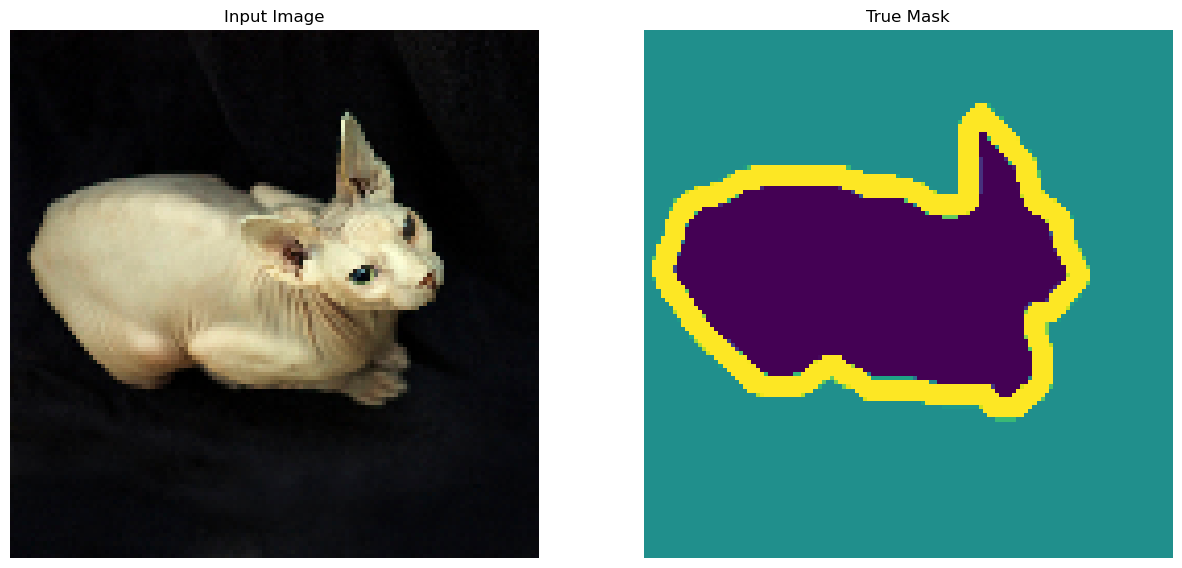

In [29]:
for image, mask in train.take(1):
  sample_image, sample_mask = image, mask
display([sample_image, sample_mask])